In [1]:
import sys
import matplotlib
%matplotlib inline
#enable importing of notebooks
import argparse
from nbfinder import NotebookFinder
sys.meta_path.append(NotebookFinder())
from notebooks.data_loader import load_classification_dataset, load_detection_dataset
from notebooks.train_val import train
from notebooks.helper_fxns import create_run_dir
from notebooks.print_n_plot import plot_ims_with_boxes
from notebooks.build_hur_classif_network import build_classif_network
from notebooks.build_hur_detection_network import build_det_network

importing Jupyter notebook from notebooks/data_loader.ipynb
importing Jupyter notebook from notebooks/train_val.ipynb
importing Jupyter notebook from notebooks/helper_fxns.ipynb
importing Jupyter notebook from notebooks/build_hur_classif_network.ipynb
importing Jupyter notebook from notebooks/print_n_plot.ipynb
importing Jupyter notebook from notebooks/build_hur_detection_network.ipynb
importing Jupyter notebook from notebooks/detec_helper_fxns.ipynb


getting data...
40
running on non pretrained classif network!
Building model and compiling functions...
Building model and compiling functions...
Starting training...
Epoch 1 of 1 took 12.065s
	training los:		6.7379
	training acc:		0.1139 %
  validation loss:		6.214290
  validation accuracy:		0.00 %


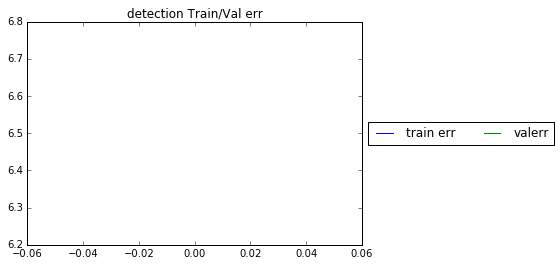

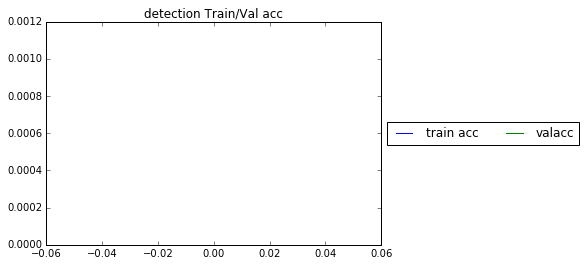

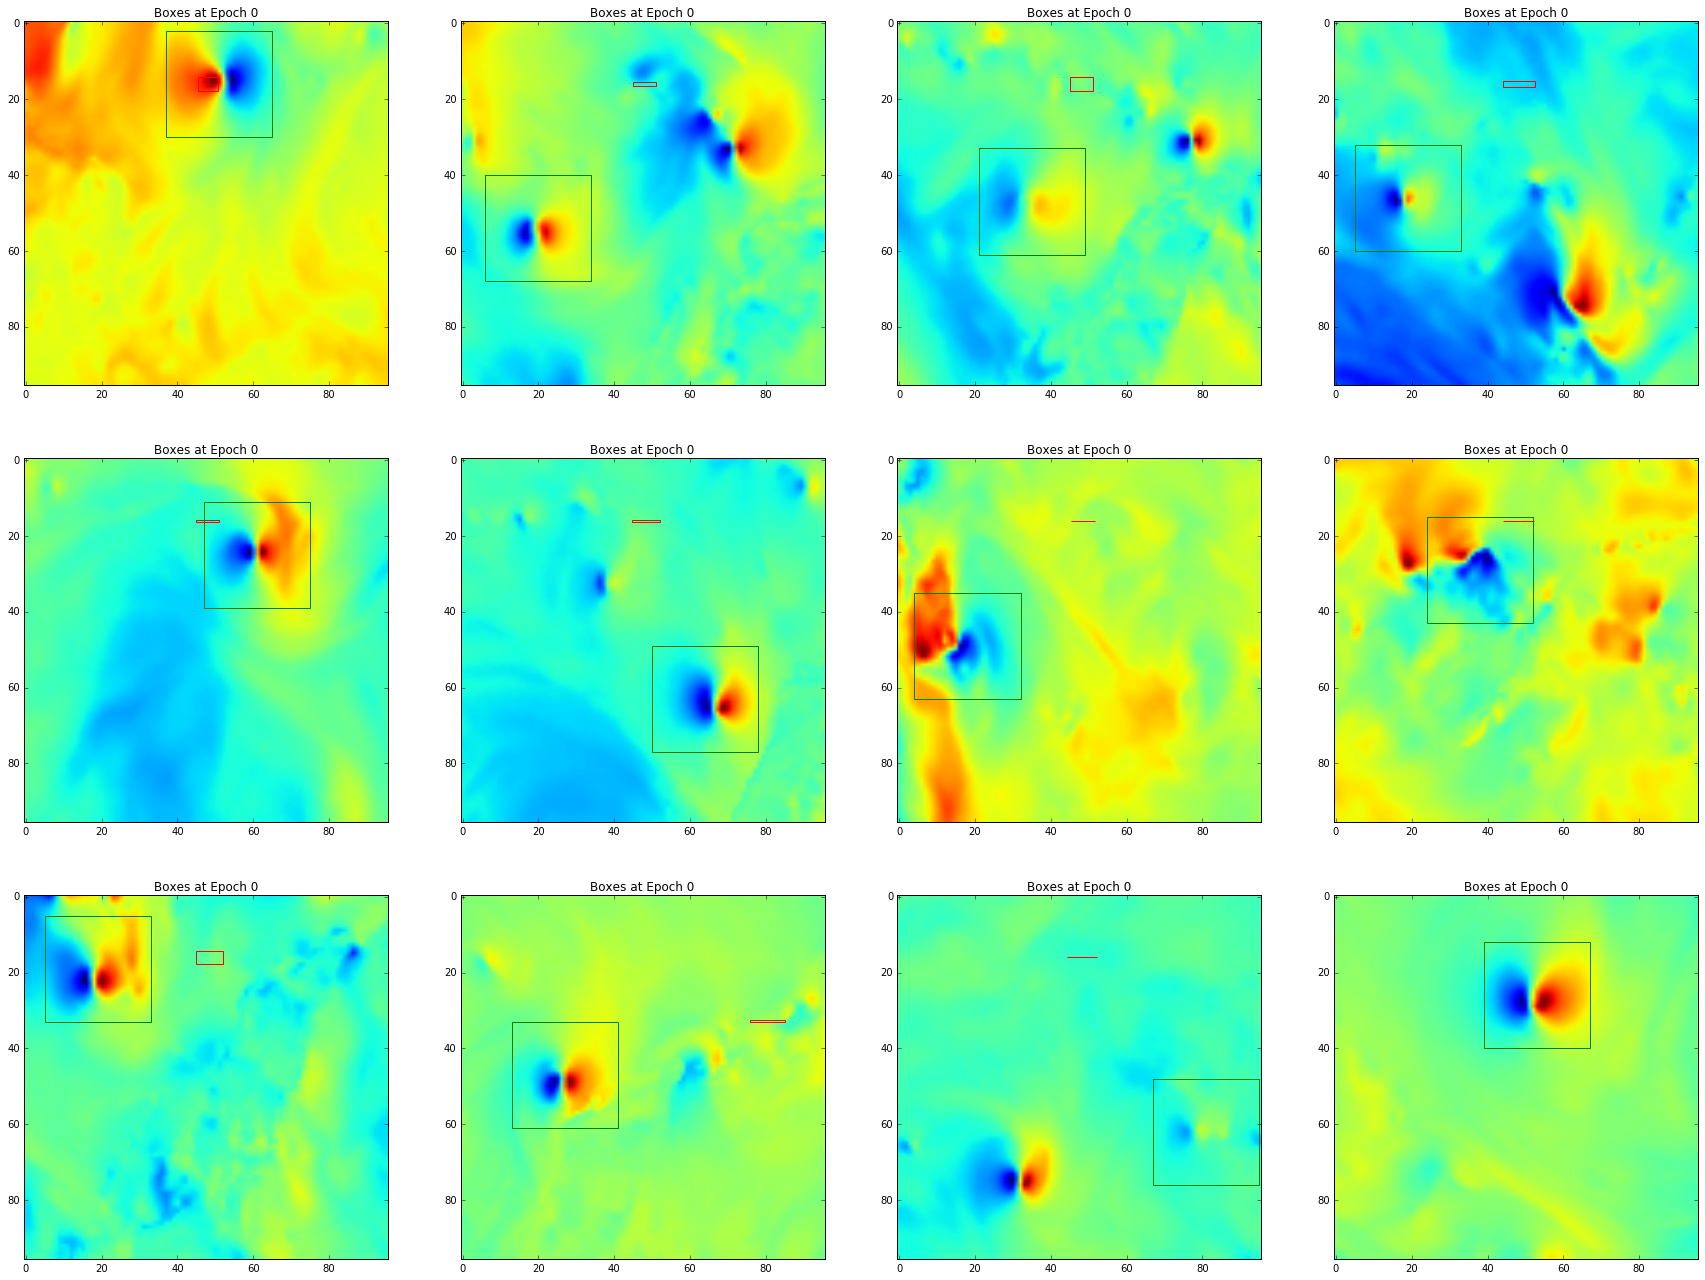

In [3]:
epochs = 1
learning_rate = 0.0001
# parser = argparse.ArgumentParser()
# parser.add_argument('-e', '--epochs', type=int, default=10,
#     help='number of epochs for training')

# parser.add_argument('-l', '--learn_rate', default=0.0001, type=float,
#     help='the learning rate for the network')

# args = parser.parse_args()
# epochs = args.epochs
# learning_rate = args.learn_rate


train_classif=False

run_dir = create_run_dir()

# #train classifcation
if train_classif:
    x_tr, y_tr, x_te,y_te, x_val, y_val = load_classification_dataset(num_ims=40)

    classif_network_kwargs = {'num_filters':10,'num_fc_units':128, 'learning_rate': 0.001}
    class_network = train(datasets=(x_tr, y_tr, x_te,y_te, x_val, y_val),
                          num_epochs=1, 
                          network_kwargs=classif_network_kwargs, 
                          mode="classification", 
                          save_plots=True,
                          save_path=run_dir)
else:
    class_network = None


x_tr, grid_tr, box_tr, \
x_te, grid_te, box_te, \
x_val, grid_val, box_val = load_detection_dataset(num_ims=40, with_boxes=True)

datasets = (x_tr,grid_tr,box_tr, x_val, grid_val,box_val, x_te, grid_te, box_te)

detec_network_kwargs = {'grid_size': grid_tr.shape[2], 'nclass': 1, 'n_boxes':1, 
                        'learning_rate': learning_rate, 'dropout_p': 0, 'weight_decay': 0, 'num_filters': 1024}

#train detection
n = train(datasets, network_kwargs=detec_network_kwargs, num_epochs=epochs,
          mode='detection', save_path=run_dir, inmem_class_network=class_network)